In [164]:
import numpy as np

In [165]:
import matplotlib.pyplot as plt

In [166]:
Nx = 201
Nt = 101
x = np.zeros(Nx)
u = np.zeros((Nt, Nx))
t = np.zeros(Nt)
ux = np.zeros((Nt, Nx))
uxx = np.zeros((Nt, Nx))

In [167]:
x = np.linspace(-1., 1., Nx)
t = np.linspace(0., 1., Nt)

dx = x[1] - x[0]
dt = t[1] - t[0]
dx, dt

(0.010000000000000009, 0.01)

In [168]:
u[0,:] = -np.sin(np.pi*x)
u[:,0] = u[:,-1] = 0

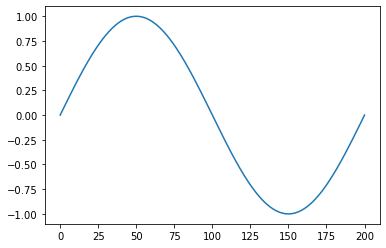

In [169]:
plt.plot(u[0])

In [170]:
for i in range(1, Nt):
    for j in range(1, Nx-1):
        ux[i-1, j] = (u[i-1, j+1] - u[i-1, j-1]) / (2. * dx)  # central scheme
        #ux[i-1, j] = (u[i-1, j+1] - u[i-1, j]) / dx
        uxx[i-1, j] = (u[i-1, j+1] - 2*u[i-1, j] + u[i-1, j-1]) / (dx*dx)

        u[i,j] = u[i-1, j] + dt * (-u[i-1, j]*ux[i-1, j] + 0.01/np.pi*uxx[i-1, j])
    
    

In [171]:
np.shape(u[::10])

(11, 201)

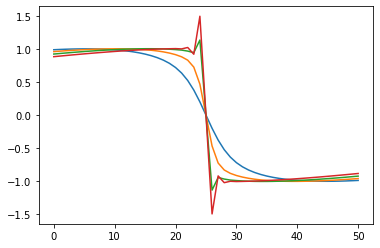

In [172]:
plt.plot(u[30:50:5,75:126].T)

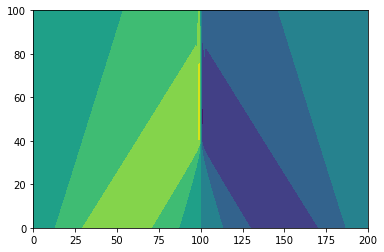

In [173]:
plt.contourf(u)

In [174]:
xx, tt = np.meshgrid(x, t)

In [175]:
from matplotlib import cm

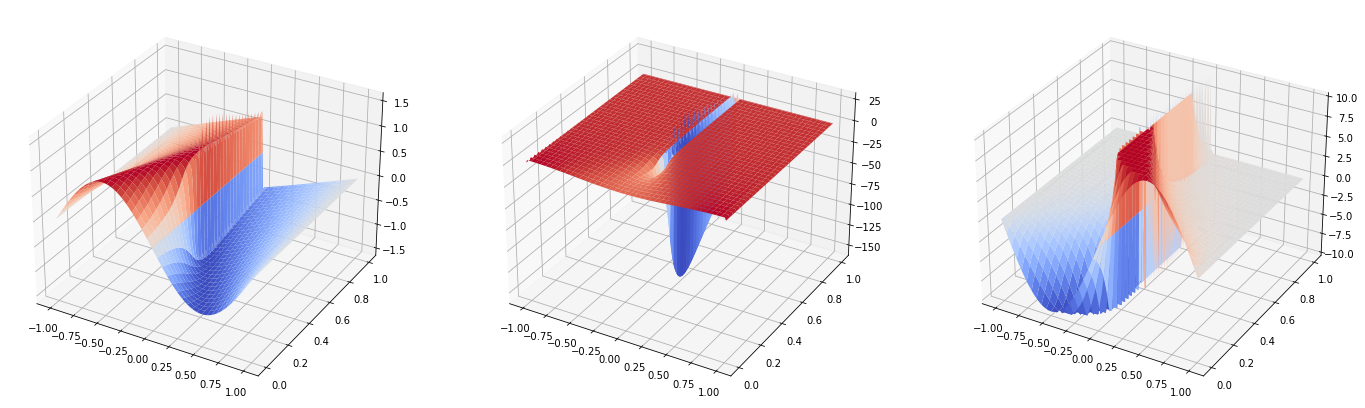

In [176]:


#fig = plt.figure(figsize=(24,8))
#ax = plt.axes(projection='3d')
fig, axes = plt.subplots(1,3, figsize=(24,8), subplot_kw={"projection": "3d"})

#ax.contourf(tt, xx, u)
#ax.contourf(xx.T, tt.T, u.T)

axes[0].plot_surface(xx.T, tt.T, u.T, cmap=cm.coolwarm)
axes[1].plot_surface(xx.T, tt.T, ux.T, cmap=cm.coolwarm)
axes[2].plot_surface(xx.T, tt.T, np.clip(uxx.T, -10, 10), cmap=cm.coolwarm)

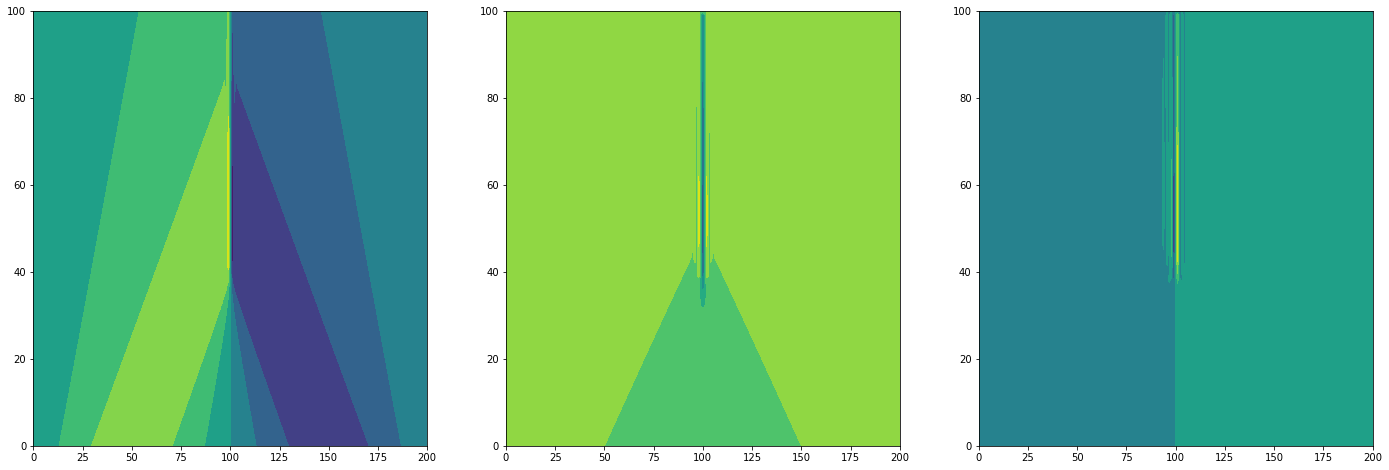

In [177]:

fig, axes = plt.subplots(1,3, figsize=(24,8))

axes[0].contourf(u)
axes[1].contourf(ux)
axes[2].contourf(uxx)

In [178]:
u

array([[ 0.        ,  0.03141076,  0.06279052, ..., -0.06279052,
        -0.03141076,  0.        ],
       [ 0.        ,  0.03041474,  0.06080239, ..., -0.06080239,
        -0.03041474,  0.        ],
       [ 0.        ,  0.02948147,  0.05893915, ..., -0.05893915,
        -0.02948147,  0.        ],
       ...,
       [ 0.        ,  0.00760508,  0.01521006, ..., -0.01521006,
        -0.00760508,  0.        ],
       [ 0.        ,  0.00754721,  0.01509433, ..., -0.01509433,
        -0.00754721,  0.        ],
       [ 0.        ,  0.00749022,  0.01498036, ..., -0.01498036,
        -0.00749022,  0.        ]])

In [179]:
import torch
from torch import nn
import torch.nn.functional as f

In [180]:
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()

        self.lin1 = nn.Linear(2, 20)
        self.lin21 = nn.Linear(20, 30)
        self.lin22 = nn.Linear(20, 10)
        self.lin31 = nn.Linear(40, 20)
        self.lin32 = nn.Linear(40, 10)
        self.lin4 = nn.Linear(30, 1)

        self.selu1 = nn.Tanh()
        self.selu2 = nn.Tanh()
        self.selu3 = nn.Tanh()

        self.dropout = nn.AlphaDropout(p=0.05)

        self.theta1 = torch.zeros(1)
        self.theta2 = torch.zeros(1)


    def forward(self, x, t):

        xt = torch.concat((x.reshape(-1,1),t.reshape(-1,1)), dim=1)
        #xt = torch.vstack((x,t))
        #print(xt.shape)


        z1 = self.dropout(self.selu1(self.lin1(xt)))

        z21 = self.dropout(self.selu2(self.lin21(z1)))
        z22 = self.dropout(torch.sin(self.lin22(z1)))
        #print(z21.shape, z22.shape)
        z2 = torch.concat((z21, z22), dim=1)

        z31 = self.dropout(self.selu3(self.lin31(z2)))
        z32 = self.dropout(torch.sin(self.lin32(z2)))
        z3 = torch.concat((z31, z32), dim=1)

        y = self.lin4(z3)

        return y

    def res(self, x, t):

        u = self.forward(x, t)

        ux = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
        uxx = torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True, retain_graph=True)[0]
        ut = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]

        return ut + u*ux - 0.01/torch.pi*uxx
        

    #def residual(self, u):





In [181]:
g = torch.Generator(device="cuda")
g.seed()
#g.manual_seed(42)

3949886626778952

In [182]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [191]:
net = NNModel().to(device)

In [192]:
optimizer = torch.optim.Adagrad(net.parameters(), lr=1e-2)

In [193]:
for i in range(10_000):
    x_samples = torch.rand((1000), generator=g, device=device).requires_grad_()
    t_samples = torch.rand((1000), generator=g, device=device).requires_grad_()
    x_samples = 2*x_samples - 1.

    # u_samples = net(x_samples, t_samples)
    # ux_samples = torch.empty_like(u_samples)
    # uxx_samples = torch.empty_like(u_samples)
    # ut_samples = torch.empty_like(u_samples)
    # for j in range(1000):
    #     print(j)
    #     ux_samples[j,0] = torch.autograd.grad(u_samples[j,0], x_samples[j,0], retain_graph=True)
    #     uxx_samples[j,0] = torch.autograd.grad(ux_samples[j,0], x_samples[j,0], retain_graph=True)
    #     ut_samples[j,0] = torch.autograd.grad(u_samples[j,0], x_samples[j,0], retain_graph=True)

    # eye = torch.eye(1000, device=device)
    # eye_v = tuple(eye[i] for i in range(1000))

    #ux_samples = torch.autograd.grad(u_samples, (x_samples[i] for i in range(1000)), retain_graph=True)
    # ux_samples = torch.autograd.grad(u_samples, x_samples, create_graph=True, retain_graph=True, allow_unused=True)
    # uxx_samples = torch.autograd.grad(ux_samples, x_samples, create_graph =True)
    # ut_samples = torch.autograd.grad(u_samples, t_samples, create_graph =True)
    
    # ux_samples = torch.autograd.functional.vjp(lambda x: net(x, t_samples), x_samples, eye_v, create_graph=True)

    # res_samples = ut_samples + u_samples*ux_samples - 0.01/np.pi*uxx_samples
    res_samples = net.res(x_samples, t_samples)    
    
    x_boundary1 = torch.rand((1000,1), generator=g, device=device)
    t_boundary1 = torch.zeros((1000,1), device=device)
    x_boundary1 = 2*x_boundary1 - 1.

    u_boundary1 = net(x_boundary1, t_boundary1)
    u_boundary1_target = -torch.sin(torch.pi*x_boundary1)

    x_boundary2 = torch.bernoulli(torch.ones((5000, 1), device=device)*0.5)*2. - 1.
    t_boundary2 = torch.rand((5000,1), generator=g, device=device)
    u_boundary2 = net(x_boundary2, t_boundary2)
    u_boundary2_target = torch.zeros((5000,1), device=device)

    loss1 = torch.sum(res_samples*res_samples)/1000 
    loss2 = f.mse_loss(u_boundary1, u_boundary1_target)
    loss3 = f.mse_loss(u_boundary2, u_boundary2_target)
    loss = loss1 + loss2 + loss3

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(i, loss1.detach().cpu().squeeze(), loss2.detach().cpu().squeeze(), loss3.detach().cpu().squeeze())


0 tensor(0.7014) tensor(0.5699) tensor(0.0656)
1 tensor(28.3364) tensor(0.5227) tensor(0.0705)
2 tensor(0.3413) tensor(0.5519) tensor(0.0524)
3 tensor(0.1739) tensor(0.5609) tensor(0.0531)
4 tensor(0.1689) tensor(0.5515) tensor(0.0530)
5 tensor(0.1453) tensor(0.5447) tensor(0.0508)
6 tensor(0.1577) tensor(0.5527) tensor(0.0517)
7 tensor(0.1612) tensor(0.5555) tensor(0.0508)
8 tensor(0.1410) tensor(0.5452) tensor(0.0517)
9 tensor(0.1522) tensor(0.5452) tensor(0.0512)
10 tensor(0.1461) tensor(0.5542) tensor(0.0490)
11 tensor(0.1385) tensor(0.5515) tensor(0.0485)
12 tensor(0.1386) tensor(0.5829) tensor(0.0480)
13 tensor(0.1422) tensor(0.5561) tensor(0.0510)
14 tensor(0.1295) tensor(0.5649) tensor(0.0476)
15 tensor(0.1293) tensor(0.5673) tensor(0.0490)
16 tensor(0.1294) tensor(0.5643) tensor(0.0488)
17 tensor(0.1231) tensor(0.5619) tensor(0.0489)
18 tensor(0.1365) tensor(0.5279) tensor(0.0471)
19 tensor(0.1276) tensor(0.5218) tensor(0.0493)
20 tensor(0.1164) tensor(0.5733) tensor(0.0500)
2

In [ ]:
torch.eye(1000, device=device)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

In [203]:
u_test = net(torch.from_numpy(xx.flatten()).float().to(device=device), torch.from_numpy(tt.flatten()).float().to(device=device))

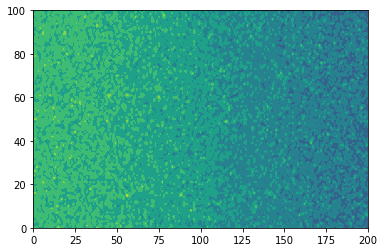

In [210]:
plt.contourf(u_test.reshape(xx.shape).detach().cpu().numpy())

In [207]:
xx.shape

(101, 201)